 # MTH8211 : Algèbre linéaire numérique appliquée
 ## Laboratoire 3 : Application de la SVD, discussions sur la performance, systèmes de point de selle
 
Geoffroy Leconte

Source images, signaux bruités: http://www.imm.dtu.dk/~pcha/HNO/ (Matrices, Spectra, and Filtering
Per Christian Hansen, James G. Nagy, and Dianne P. O'Leary)

## I) Application de la SVD: débruitage d'images

In [ ]:
using Pkg
Pkg.add("Images");
Pkg.add("ToeplitzMatrices");
Pkg.add("BenchmarkTools");
Pkg.add("DoubleFloats");

In [ ]:
using Images, LinearAlgebra, ToeplitzMatrices

$X \in \mathbb{R}^{m \times n}$ représente l'image désirée.

$B \in \mathbb{R}^{m \times n}$ représente l'image bruitée.

Si le bruitage des lignes est indépendant de celui des colonnes, il existe $A_c \in \mathbb{R}^{m \times m}$ et $A_r \in \mathbb{R}^{n \times n}$.

$A_c X A_r^T = B$.

L'implémentation naive consiste à calculer:

$$X_{\textrm{naive}} = A_c^{-1} B A_r^{-T}$$

In [5]:
function challenge1(m,n,noise)
    X = zeros(m,n)
    I = Int(round(m/5)):Int(round(3*m/5))
    J = Int(round(n/5)):Int(round(3*n/5))
    X[I,J] .= 0.5
    for i=1:m
     for j=1:n
       if (i - round(3 * m / 5))^2 + (j - round(5 * n / 8))^2 < round(max(m, n) / 5)^2
          X[i,j] = 1
       end
     end
    end
    c = zeros(m)
    c[1:5] .= 5:-1:1 ./ 15
    Ac = SymmetricToeplitz(c)
    c = zeros(n)
    c[1:5] .= 5:-1:1 ./ 15
    r = zeros(n)
    r[1:10] .= 5:-0.5:0.5 ./ 15
    Ar = Toeplitz(c, r)
    B = Ac * X * Ar' + noise * randn(m,n)
    return B, Ac, Ar, X
end
m = n = 256
noise = 0.01
B, Ac, Ar, X = challenge1(m, n, noise);

1) Calculer $X_{\textrm{naive}}$.

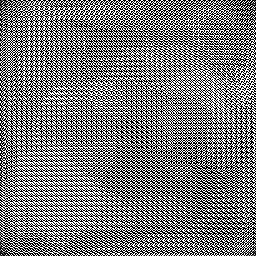

In [24]:
Xnaive = (Ar \ (Ac \ B)')'
Gray.(Xnaive)
# Ac \ B / Ar'

2) Soit $E$ le bruit. $X_{\textrm{naive}} = X + A_c^{-1} E A_r^{-T}$. Calculez le bruit inversé $  A_c^{-1} E A_r^{-T}$ et comparez avec la valeur de $B$.

In [7]:
E = B - X
NoiseInv = (Ar \ (Ac \ E)')'
norm(NoiseInv) / norm(B)

0.2983029785331221

3) Effectuez une décomposition en valeurs singulières de $A_c$ et $A_r$. Utilisez la décomposition en valeur singulières pour réduire la contribution du bruit. Calculez l'image débruitée et comparez avez la solution exacte.

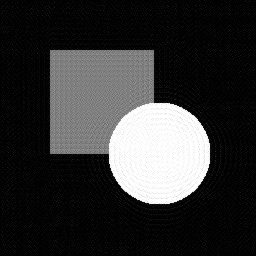

In [8]:
Fc = svd(Matrix(Ac))
Fr = svd(Matrix(Ar))
n_svd = sum(abs.(Fc.S) .≥ 0.1)
X_debruit = Fc.V[1:end, 1:n_svd] * Diagonal(1 ./ Fc.S[1:n_svd]) * Fc.U[1:end, 1:n_svd]' * 
    B *
    Fr.U[1:end, 1:n_svd] * Diagonal(1 ./ Fr.S[1:n_svd]) * Fr.V[1:end, 1:n_svd]'
Gray.(X_debruit)

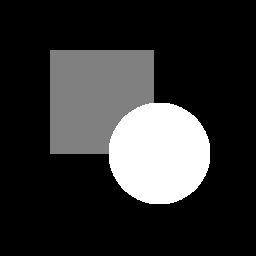

In [9]:
Gray.(X)

## II) Retour plus en détail sur la performance et les fonctions de BLAS et LAPACK 

BLAS (Basic Linear Algebra Subprograms) est une suite de routines pour effectuer des opérations vectorielles/matricielles. Elles sont optimisées spécifiquement pour divers types de plateformes, ce qui les rend particulièrement performantes.

In [11]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1342
┌ Warning: Module JSON with build ID 1116729199577577 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf].
└ @ Base loading.jl:1047


In [25]:
T = Float64
n = 10000
a = rand(T, n)
b = rand(T, n)
c = rand(T, n);

In [13]:
@benchmark dot($a, $b) # interpoler a et b avec $ pour éviter le problème du benchmark avec des variables globales

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.423 μs …  11.706 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.633 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.775 μs ± 577.501 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▄▅█▆▄▃▂▂▃▃▂▁▃                                              ▂
  ██████████████▇▇▆▆▅▆▅▄▅▁▅▄▅▆▆▇▆▆▆▇▇▇▇▇▆▆▇▆▆▅▅▄▄▅▅▅▅▅▅▃▁▄▃▅▄ █
  1.42 μs      Histogram: log(frequency) by time      4.71 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [14]:
function my_custom_dot(a::Vector{T}, b::Vector{T}) where {T}
    res = zero(T)
    n = length(a)
    @assert n == length(b)
    for i=1:n
        res += a[i] * b[i]
    end
    return res 
end

my_custom_dot (generic function with 1 method)

In [15]:
@benchmark my_custom_dot($a, $b)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.577 μs … 286.573 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.958 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.864 μs ±   5.031 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇▆▄▃▁▃▂                                                     ▂
  ████████▇▅▅▄▄▄▁▄▄▃▄▃▄▃▃▃▅▅▃▅▄▅▅▄▃▄▁▁▄▃▃▅▆▆▄▄▄▄▅▆▇▇▅▇▇▅▆▆▄▄▅▆ █
  10.6 μs       Histogram: log(frequency) by time        32 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [26]:
@code_lowered dot(a, b) # appel à BLAS.dot

CodeInfo(
1 ─ %1 = LinearAlgebra.BLAS.dot
│   %2 = (%1)(x, y)
└──      return %2
)

Les fonctions de BLAS ne gèrent pas tous les types:

In [ ]:
using DoubleFloats

In [27]:
T = Double64 # plus précis que Float64
n = 10000
a = rand(T, n)
b = rand(T, n)
c = rand(T, n);

In [28]:
@code_lowered dot(a, b) # retourne à l'implémentation en pur julia car non implémenté avec BLAS

CodeInfo(
1 ─       Core.NewvarNode(:(@_4))
│         Core.NewvarNode(:(s))
│         lx = LinearAlgebra.length(x)
│   %4  = lx
│   %5  = LinearAlgebra.length(y)
│   %6  = %4 != %5
└──       goto #3 if not %6
2 ─ %8  = lx
│   %9  = LinearAlgebra.length(y)
│   %10 = Base.string("first array has length ", %8, " which does not match the length of the second, ", %9, ".")
│   %11 = LinearAlgebra.DimensionMismatch(%10)
└──       LinearAlgebra.throw(%11)
3 ┄ %13 = lx == 0
└──       goto #5 if not %13
4 ─ %15 = LinearAlgebra.eltype(x)
│   %16 = LinearAlgebra.zero(%15)
│   %17 = LinearAlgebra.eltype(y)
│   %18 = LinearAlgebra.zero(%17)
│   %19 = LinearAlgebra.dot(%16, %18)
└──       return %19
5 ─ %21 = LinearAlgebra.first(x)
│   %22 = LinearAlgebra.first(y)
│   %23 = LinearAlgebra.dot(%21, %22)
│         s = LinearAlgebra.zero(%23)
│   %25 = LinearAlgebra.eachindex(x)
│   %26 = LinearAlgebra.eachindex(y)
│   %27 = LinearAlgebra.zip(%25, %26)
│         @_4 = Base.iterate(%27)
│   %29 = @_4 === 

In [ ]:
@benchmark BLAS.dot($a, $b)

In [30]:
@benchmark dot($a, $b)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  152.143 μs … 438.153 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     156.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   165.681 μs ±  25.188 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇▃█▂▇▂▁ ▁▁▁▁    ▁▁ ▁ ▁                                        ▁
  ███████████████▇██████▇███▇▇▇▆▇▇▇█▇▆▆▇▆▆▆▆▇▆▅▆▅▅▆▆▆▅▅▅▅▅▆▅▅▅▅ █
  152 μs        Histogram: log(frequency) by time        281 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [31]:
@benchmark my_custom_dot($a, $b)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  152.067 μs …  1.580 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     156.744 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   164.465 μs ± 28.062 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █▁▆▃▁ ▁▁▁      ▁▁ ▁                                        ▂
  ████████████▇▇▇▇█████▇██▇▇██▇▇▇▆▇▇▇▇█▆▇▇▆▅▆▆▆▆▆▆▅▆▄▅▆▆▆▅▅▄▆▅ █
  152 μs        Histogram: log(frequency) by time       273 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

Julia utilise d'autres opérations de BLAS qui sont utilisées à travers d'autres fonctions courantes.

Les opérations d'algèbre linéaire dense sont effectuées avec la bibliothèque LAPACK, qui elle-même utilise BLAS.
Cette bibliothèque ne fonctionne qu'avec les types `Float32, Float64, ComplexF32, ComplexF64`.

Les fonction de LAPACK disponibles dans la [documentation de Julia](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LAPACK-functions) ne sont pas vouées à être utilisées directement. Elle seront appelées par d'autres fonctions de plus haut niveau, afin de pouvoir utiliser le "dispatch multiple" suivant le type d'entrées fournies.

Exemple avec la factorisation LU:

In [32]:
T = Float64
n = 1000
A = rand(T, n, n)
@code_typed lu(A) # on voit l'appel à LinearAlgebra.LAPACK.getrf!

CodeInfo(
1 ── %1  = $(Expr(:foreigncall, :(:jl_array_copy), Ref{Matrix{Float64}}, svec(Any), 0, :(:ccall), Core.Argument(2)))::Matrix{Float64}
│    %2  = Base.sle_int(1, 1)::Bool
└───       goto #3 if not %2
2 ── %4  = Base.sle_int(1, 0)::Bool
└───       goto #4
3 ──       nothing::Nothing
4 ┄─ %7  = φ (#2 => %4, #3 => false)::Bool
└───       goto #6 if not %7
5 ──       invoke Base.getindex(()::Tuple, 1::Int64)::Union{}
└───       unreachable
6 ──       goto #7
7 ──       goto #8
8 ──       goto #9
9 ──       goto #10
10 ─ %15 = LinearAlgebra.LAPACK.getrf!::typeof(LinearAlgebra.LAPACK.getrf!)
│    %16 = invoke %15(%1::Matrix{Float64})::Tuple{Matrix{Float64}, Vector{Int64}, Int64}
└───       goto #16 if not true
11 ─ %18 = Base.getfield(%16, 3, true)::Int64
│    %19 = (%18 === 0)::Bool
└───       goto #13 if not %19
12 ─       goto #14
13 ─ %22 = LinearAlgebra.SingularException(%18)::Any
│          LinearAlgebra.throw(%22)::Union{}
└───       unreachable
14 ─       goto #15
15 ─      

In [33]:
T = Double64
n = 1000
A = rand(T, n, n)
@code_typed lu(A) # ici, appel à generic_lufact! pour les types non supportés par LAPACK.

CodeInfo(
1 ── %1  = $(Expr(:foreigncall, :(:jl_array_copy), Ref{Matrix{Double64}}, svec(Any), 0, :(:ccall), Core.Argument(2)))::Matrix{Double64}
│    %2  = Base.sle_int(1, 1)::Bool
└───       goto #3 if not %2
2 ── %4  = Base.sle_int(1, 0)::Bool
└───       goto #4
3 ──       nothing::Nothing
4 ┄─ %7  = φ (#2 => %4, #3 => false)::Bool
└───       goto #6 if not %7
5 ──       invoke Base.getindex(()::Tuple, 1::Int64)::Union{}
└───       unreachable
6 ──       goto #7
7 ──       goto #8
8 ──       goto #9
9 ──       goto #10
10 ─ %15 = LinearAlgebra.generic_lufact!::typeof(LinearAlgebra.generic_lufact!)
│    %16 = Base.sle_int(1, 1)::Bool
└───       goto #12 if not %16
11 ─ %18 = Base.sle_int(1, 0)::Bool
└───       goto #13
12 ─       nothing::Nothing
13 ┄ %21 = φ (#11 => %18, #12 => false)::Bool
└───       goto #15 if not %21
14 ─       invoke Base.getindex(()::Tuple, 1::Int64)::Union{}
└───       unreachable
15 ─       goto #16
16 ─       goto #17
17 ─       goto #18
18 ─       goto #19

**Exercice:**
Résolvez un système `Ax=b` dense aléatoire de taille 1000 où `A` est définie positive avec une factorisation de Cholesky en utilisant `cholesky` pour la factorisation et `ldiv!` pour la résolution du système.
Comparez les vitesses d'exécution de chaque fonction en `Float64` et `Float32` avec `@benchmark`, et mesurez les résidus obtenus. 


In [34]:
T = Float64
n = 1000
A = rand(T, n, n)
A = A' * A + I
b = rand(T, n)
x = similar(b);

In [35]:
@benchmark cholesky($A)

BenchmarkTools.Trial: 592 samples with 1 evaluation.
 Range (min … max):  5.768 ms … 75.689 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     7.348 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.439 ms ±  3.720 ms  ┊ GC (mean ± σ):  8.57% ± 14.94%

     ▂▆▆█▅█▂▂                                                 
  ▄▅██████████▅▅▄▃▃▅▄▃▄▄▅▃▃▄▃▃▂▂▂▁▃▂▃▃▃▄▄▄▃▅▃▃▃▃▃▂▃▁▃▂▂▁▂▁▁▃ ▃
  5.77 ms        Histogram: frequency by time        16.6 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 4.

In [36]:
F = cholesky(A)
@benchmark ldiv!($x, $F, $b)

BenchmarkTools.Trial: 4625 samples with 1 evaluation.
 Range (min … max):  810.869 μs …  12.311 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     978.983 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.066 ms ± 323.609 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▃█▅▃                                                       
  ▁▂▂██████▇▆▆▅▅▄▅▄▄▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  811 μs           Histogram: frequency by time         1.88 ms <

 Memory estimate: 96 bytes, allocs estimate: 2.

In [37]:
ldiv!(x, F, b)
norm(A * x - b)

8.831132889864814e-12

In [38]:
T = Float32
n = 1000
A = rand(T, n, n)
A = A' * A + I
b = rand(T, n)
x = similar(b);

In [39]:
@benchmark cholesky($A)

BenchmarkTools.Trial: 1067 samples with 1 evaluation.
 Range (min … max):  2.948 ms … 43.582 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     3.917 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.668 ms ±  2.589 ms  ┊ GC (mean ± σ):  8.08% ± 12.45%

  ▁▅▇█▇▇▆▅▅▄▂▃▃▂▁▁                                            
  ████████████████▇▇▅▇▅▄▆▁▅▄▆▄▁▁▁▁▄▁▄▄▁▁▁▁▄▁▄▄▅▁▆▄▄▆█▇▆██▅█▅ █
  2.95 ms      Histogram: log(frequency) by time     13.3 ms <

 Memory estimate: 3.81 MiB, allocs estimate: 4.

In [40]:
F = cholesky(A)
@benchmark ldiv!($x, $F, $b)

BenchmarkTools.Trial: 7436 samples with 1 evaluation.
 Range (min … max):  528.157 μs …  72.436 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     569.074 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   664.034 μs ± 898.180 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▇▅▄▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁                                   ▁
  ██████████████████████████████▇▇▇▇▇▇▇▇▇▇▆▆▅▄▅▆▄▄▅▄▂▅▅▄▃▅▂▄▄▂▄ █
  528 μs        Histogram: log(frequency) by time       1.33 ms <

 Memory estimate: 96 bytes, allocs estimate: 2.

In [41]:
ldiv!(x, F, b)
Float64(norm(A * x - b))

0.007308427710086107

## III) Résolution de systèmes de point de selle par méthodes directes

Dans cette partie, on va voir comment résoudre différents problèmes menant à la résolution d'un système de point de selle en utilisant des factorisations.

Rappel: un système de point de selle s'écrit sous la forme

$$\begin{bmatrix} M & A^T \\ A & 0 \end{bmatrix}\begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} b \\ c \end{bmatrix},$$
où $M \succ 0$.

1) Ecrire les conditions d'optimalité du problème

$\arg \min_x \tfrac{1}{2}\|Ax-b\|_2^2, \quad A \in \mathbb{R}^{m \times n}, m \ge n$.

Reformuler ces conditions d'optimalité sous la forme d'un système de point de selle.
Comparer le temps de résolution du système de point de selle (en utilisant une factorisation appropriée) avec le temps de résolution du problème de moindre carrés en utilisant la factorisation $QR$. 

**Solution**: les conditions d'optimalité sont:
$$A^T A x = A^T b.$$

Avec $r = b - Ax$, on a pour conditions d'optimalité:

$$\begin{bmatrix} I & A \\ A^T & 0 \end{bmatrix} \begin{bmatrix} r \\ x \end{bmatrix} = \begin{bmatrix} b \\ 0 \end{bmatrix}$$

In [42]:
m, n = 1000, 800
A = rand(m, n)
b = rand(m);

In [43]:
function solve_saddle_pt(A, b)
    m, n = size(A)
    K = [I A; A' zeros(n, n)]
    rhs = [b; zeros(n)]
    F = bunchkaufman(K)
    sol = F \ rhs
    return sol[1:m], sol[m+1:end]
end
r1, x1 = solve_saddle_pt(A, b)
println(norm(b- A * x1 - r1))

6.013859076504488e-12


In [44]:
function solve_qr(A, b)
    m, n = size(A)
    F = qr(A)
    x = F \ b # résout min ||Rx - Qᵀb|| en interne 
    return b - A *x, x
end
r2, x2 = solve_qr(A, b)
println(norm(b - A * x2 - r2))

0.0


In [45]:
println(norm(x2 - x1))
println(norm(r2 - r1))

8.303819991930864e-13
6.545004455100114e-13


In [46]:
@benchmark solve_saddle_pt($A, $b)

BenchmarkTools.Trial: 69 samples with 1 evaluation.
 Range (min … max):  61.522 ms … 129.206 ms  ┊ GC (min … max): 0.00% … 5.00%
 Time  (median):     70.917 ms               ┊ GC (median):    8.99%
 Time  (mean ± σ):   72.542 ms ±  10.625 ms  ┊ GC (mean ± σ):  7.48% ± 5.51%

     ▁▁     █▁  ▄▁ ▆                                            
  ▆▆▇██▆▄▄▆▄██▇▆██▇█▆▄▁▆▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▄ ▁
  61.5 ms         Histogram: frequency by time          108 ms <

 Memory estimate: 56.22 MiB, allocs estimate: 112.

In [47]:
@benchmark solve_qr($A, $b)

BenchmarkTools.Trial: 179 samples with 1 evaluation.
 Range (min … max):  18.989 ms … 55.469 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     25.129 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.940 ms ±  7.840 ms  ┊ GC (mean ± σ):  2.58% ± 6.13%

  ▃▂   █▂▃                                                     
  ██▄▄▅███▇▄▆▆▇▄▇▆▃▁▆▄▄▄▃▄▇▄▇▄▄▃▅▄▄▃▄▁▁▁▃▃▄▃▄▃▄▃▃▃▁▃▃▁▁▁▁▁▃▁▃ ▃
  19 ms           Histogram: frequency by time        50.8 ms <

 Memory estimate: 6.58 MiB, allocs estimate: 11.

Verdict: QR est plus rapide! Mais pourquoi cet exercice alors?

Parce que certains systèmes structurés peuvent se reformuler comme un problème d'optimisation qui est beaucoup plus rapide à résoudre.

### IV) Pour aller plus loin: réduire les allocations pour un code plus performant

La plus grande source d'allocations lorsqu'on fait de l'algèbre linéaire numérique est souvent la création de vecteurs ou de matrices.
Si on utilise une boucle `for` ou `while` avec des allocations à chaque itérations de la boucle, cela peut ralentir beaucoup le code.

On peut mesurer le nombre d'allocations avec la macro `@allocated`.

NOTE: au premier appel d'une fonction, elle est compilée et cela entraine un plus grand temps d'éxécution et des allocations. Les appels suivants ne souffrent pas de ce problème.

Le "broadcasting" est souvent un moyen simple de réduire le nombre d'allocations.
Au lieu de par exemple sommer deux vecteurs et de stocker le résultat dans un nouveau vecteur, on utilise `.=` et `.+` (ou alors `@.` avant les opérations souhaitées) pour effectuer les opérations éléments par éléments et les stocker dans un vecteur pré-alloué. 


In [48]:
@allocated ones(100)

896

In [49]:
n = 1000
a, b, c = rand(n), rand(n), rand(n);

In [50]:
@allocated d = a + b

8128

In [51]:
@allocated c .= a .+ b

2871671

In [52]:
@allocated @. c = a + b

64

In [53]:
@benchmark @. $c = $a + $b

BenchmarkTools.Trial: 10000 samples with 925 evaluations.
 Range (min … max):  108.843 ns …  4.435 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     112.809 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   125.556 ns ± 64.339 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆█▆▄▂   ▁▁        ▁                                          ▁
  ████████████████████████▇████▇▇▇█▇▇▇▇▇▆▇▆▆▆▆▄▆▅▅▆▆▄▅▆▆▅▅▅▄▃▅ █
  109 ns        Histogram: log(frequency) by time       252 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

Le broadcasting dans le cas précédent est une manière plus pratique d'écrire la fonction:

In [54]:
function my_custom_sum!(c, a, b)
    n = length(c)
    @assert n == length(a) == length(b)
    for i=1:n
        c[i] = a[i] + b[i]
    end
    return c
end

my_custom_sum! (generic function with 1 method)

Une deuxième source d'allocations qu'il est souvent facile d'éviter et l'usage de matrices/ vecteurs construits à partir d'autres matrices/vecteurs.
La fonction `view` et la macro `@views` permettent de contourner ce problème.

In [55]:
@allocated dot(a[1:100], b[1:100])

2992

In [56]:
@allocated dot(view(a, 1:100), view(b, 1:100))

1322410

In [57]:
@allocated @views dot(a[1:100], b[1:100])

17216

NOTE: `view` et `@views` ne créent pas un nouveau vecteur contenant `a[1:100]`. Si vous avez besoin de `a[1:100]` sous forme de vecteur par la suite, alors il ne faut pas les utiliser, et privilégier une copie.

**Attention**: même si réduire le nombre d'allocations dans les boucles permet souvent de réduire les temps de calculs, dans certains cas il peut être préférable de garder un code qui alloue. La manière la plus sûre de regarder si la dimininution du nombre d'allocations a un effet positif est de mesurer le temps d'exécution de votre code, avec `@benchmark` par exemple.